In [ ]:
%pip install pandas numpy scikit-learn matplotlib seaborn requests


In [10]:
import pandas as pd
import requests
from time import sleep


##Using the Ergast APIs to get data for the last 3 years
def get_race_results(year):
    all_data = []
    for round_num in range(1, 23):  # Usually max 22 races/year
        url = f"https://ergast.com/api/f1/{year}/{round_num}/results.json?limit=100"
        res = requests.get(url).json()
        races = res['MRData']['RaceTable']['Races']
        if not races:
            continue

        race = races[0]
        race_name = race['raceName']
        race_date = race['date']
        for result in race['Results']:
            all_data.append({
                "season": year,
                "round": round_num,
                "race_name": race_name,
                "race_date": race_date,
                "driver_id": result['Driver']['driverId'],
                "driver_name": f"{result['Driver']['givenName']} {result['Driver']['familyName']}",
                "constructor": result['Constructor']['name'],
                "grid": int(result['grid']),
                "position": int(result['position']),
                "status": result['status'],
                "points": float(result['points'])
            })
        sleep(0.25)
    return pd.DataFrame(all_data)


In [ ]:
# Fetch for 2022 and 2023
df_2022 = get_race_results(2022)
df_2023 = get_race_results(2023)
df_2024=  get_race_results(2024) 

# Combining all three years information
full_results_df = pd.concat([df_2022, df_2023,df_2024], ignore_index=True)

,season,round,race_name,race_date,driver_id,driver_name,constructor,grid,position,status,points
0,2022,1,Bahrain Grand Prix,2022-03-20,leclerc,Charles Leclerc,Ferrari,1,1,Finished,26.0
1,2022,1,Bahrain Grand Prix,2022-03-20,sainz,Carlos Sainz,Ferrari,3,2,Finished,18.0
2,2022,1,Bahrain Grand Prix,2022-03-20,hamilton,Lewis Hamilton,Mercedes,5,3,Finished,15.0
3,2022,1,Bahrain Grand Prix,2022-03-20,russell,George Russell,Mercedes,9,4,Finished,12.0
4,2022,1,Bahrain Grand Prix,2022-03-20,kevin_magnussen,Kevin Magnussen,Haas F1 Team,7,5,Finished,10.0


In [ ]:
# Summarizing constructors by race track and teamname

def summarize_constructors(df):
    summary = df.groupby(['race_name', 'constructor']).agg(
        total_points=('points', 'sum'),
        avg_finish_position=('position', 'mean'),
        avg_grid_position=('grid', 'mean'),
        grid_finish_delta=('grid', lambda x: (x - df.loc[x.index, 'position']).mean()),
        dnf_count=('status', lambda x: (x != 'Finished').sum()),
        drivers_used=('driver_id', 'nunique')
    ).reset_index()
    
    return summary

In [ ]:
constructor_summary_df = summarize_constructors(full_results_df)
constructor_summary_df

,race_name,constructor,total_points,avg_finish_position,avg_grid_position,grid_finish_delta,dnf_count,drivers_used
0,Abu Dhabi Grand Prix,Alfa Romeo,0.0,15.750000,17.500000,1.750000,3,2
1,Abu Dhabi Grand Prix,AlphaTauri,4.0,11.000000,12.250000,1.250000,1,3
2,Abu Dhabi Grand Prix,Alpine F1 Team,6.0,13.000000,10.000000,-3.000000,1,3
3,Abu Dhabi Grand Prix,Aston Martin,12.0,8.750000,10.750000,2.000000,0,3
4,Abu Dhabi Grand Prix,Ferrari,48.0,6.500000,6.250000,-0.250000,1,2
...,...,...,...,...,...,...,...,...
287,United States Grand Prix,Mercedes,47.0,9.500000,8.666667,-0.833333,2,2
288,United States Grand Prix,RB F1 Team,2.0,11.500000,14.500000,3.000000,1,2
289,United States Grand Prix,Red Bull,95.0,3.333333,6.166667,2.833333,0,2
290,United States Grand Prix,Sauber,0.0,18.000000,17.000000,-1.000000,2,2


In [ ]:
#Sort by `total_points` → shows which teams dominated each GP.
def top_constructors_by_points(df):
    return df.sort_values(by=["race_name", "total_points"], ascending=[True, False])
    
def overachieving_constructors(df):
    return df[df["grid_finish_delta"] < 0].sort_values(by="grid_finish_delta")

def underperforming_constructors(df):
    return df[(df["grid_finish_delta"] > 0) & (df["avg_grid_position"] <= 5)].sort_values(by="grid_finish_delta", ascending=False)


def constructors_with_reliability_issues(df):
    return df[df["dnf_count"] > 0].sort_values(by="dnf_count", ascending=False)


In [14]:
top_teams=top_constructors_by_points(constructor_summary_df)
overachievers=overachieving_constructors(constructor_summary_df)
underperformers=underperforming_constructors(constructor_summary_df)
dnf_risks=constructors_with_reliability_issues(constructor_summary_df)

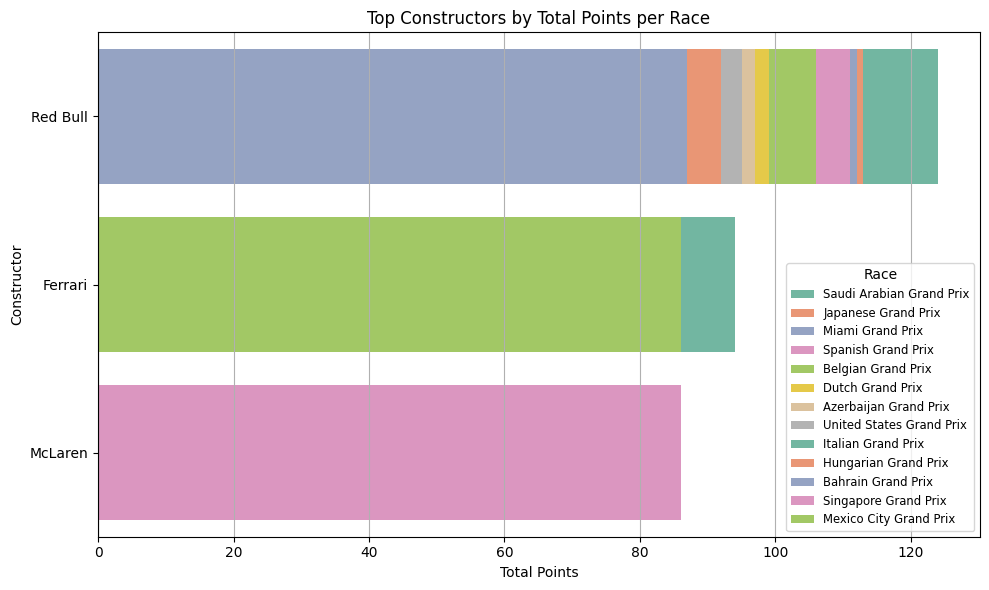

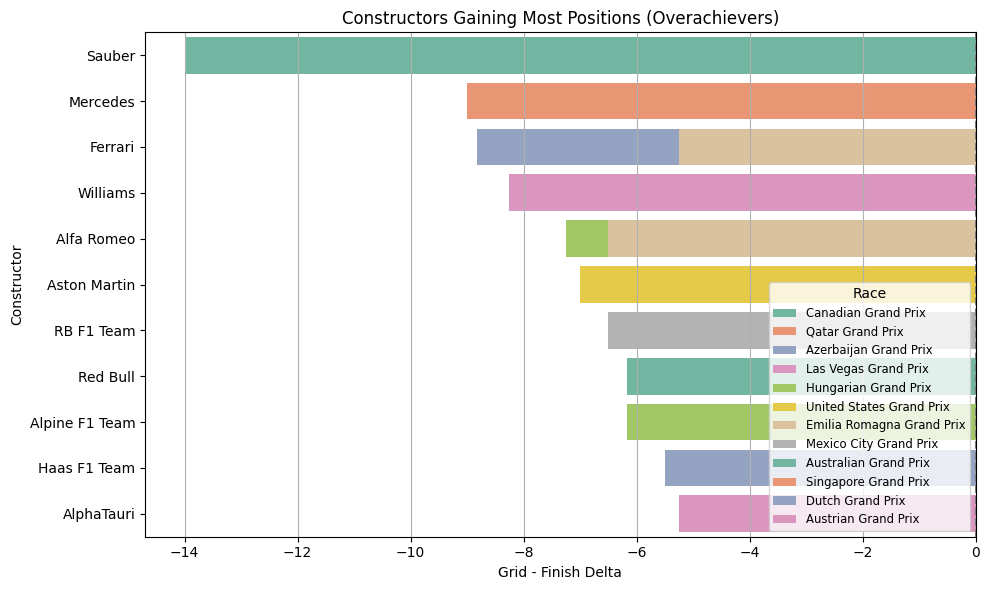

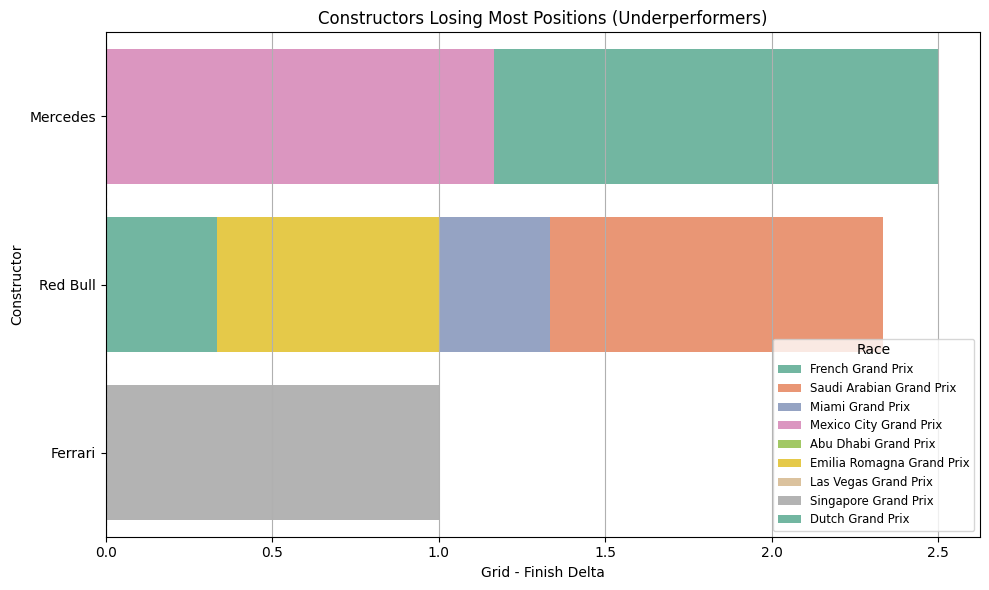

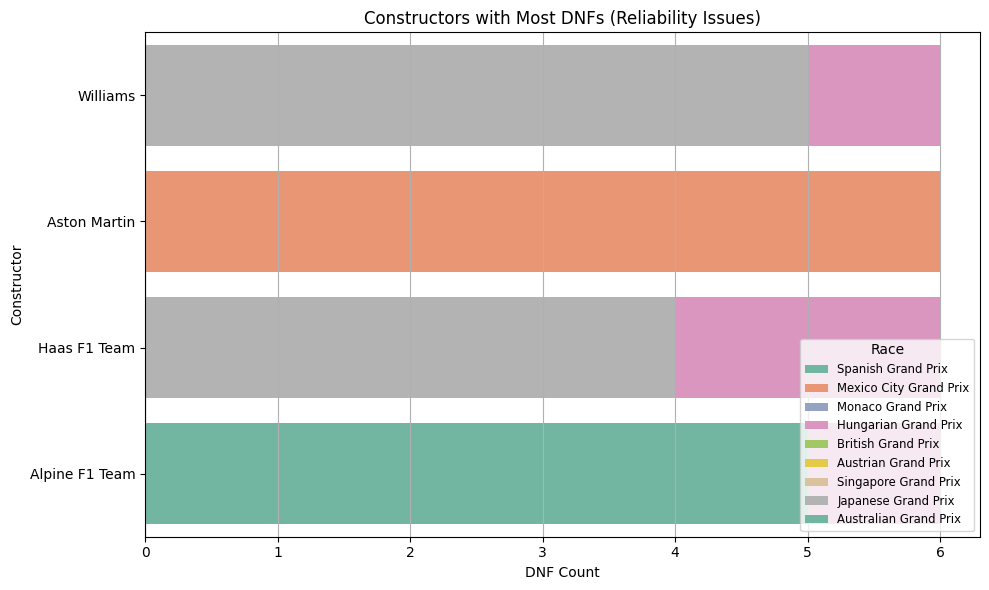

In [15]:
# Normalize values for similarity comparison
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

def plot_constructors_with_in_chart_legend(df, value_col, title, xlabel):
    if df.empty:
        print(f"⚠️ Skipping plot: No data for '{title}'")
        return

    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(
        data=df,
        y="constructor",
        x=value_col,
        hue="race_name",
        dodge=False,
        palette="Set2"
    )
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Constructor")
    plt.axvline(0, color="gray", linestyle="--" if "Delta" in xlabel else "-")
    plt.grid(True, axis='x')

    # Adjust legend placement to be inside the chart
    handles, labels = barplot.get_legend_handles_labels()
    barplot.legend(
        handles=handles,
        labels=labels,
        title="Race",
        loc="lower right",
        frameon=True,
        fontsize='small',
        title_fontsize='medium'
    )

    plt.tight_layout()
    plt.show()

# Replot using the updated function
plot_constructors_with_in_chart_legend(
    top_teams.sort_values(by="total_points", ascending=False).head(15),
    "total_points",
    "Top Constructors by Total Points per Race",
    "Total Points"
)

plot_constructors_with_in_chart_legend(
    overachievers.sort_values(by="grid_finish_delta").head(15),
    "grid_finish_delta",
    "Constructors Gaining Most Positions (Overachievers)",
    "Grid - Finish Delta"
)

plot_constructors_with_in_chart_legend(
    underperformers.sort_values(by="grid_finish_delta", ascending=False).head(15),
    "grid_finish_delta",
    "Constructors Losing Most Positions (Underperformers)",
    "Grid - Finish Delta"
)

plot_constructors_with_in_chart_legend(
    dnf_risks.sort_values(by="dnf_count", ascending=False).head(15),
    "dnf_count",
    "Constructors with Most DNFs (Reliability Issues)",
    "DNF Count"
)


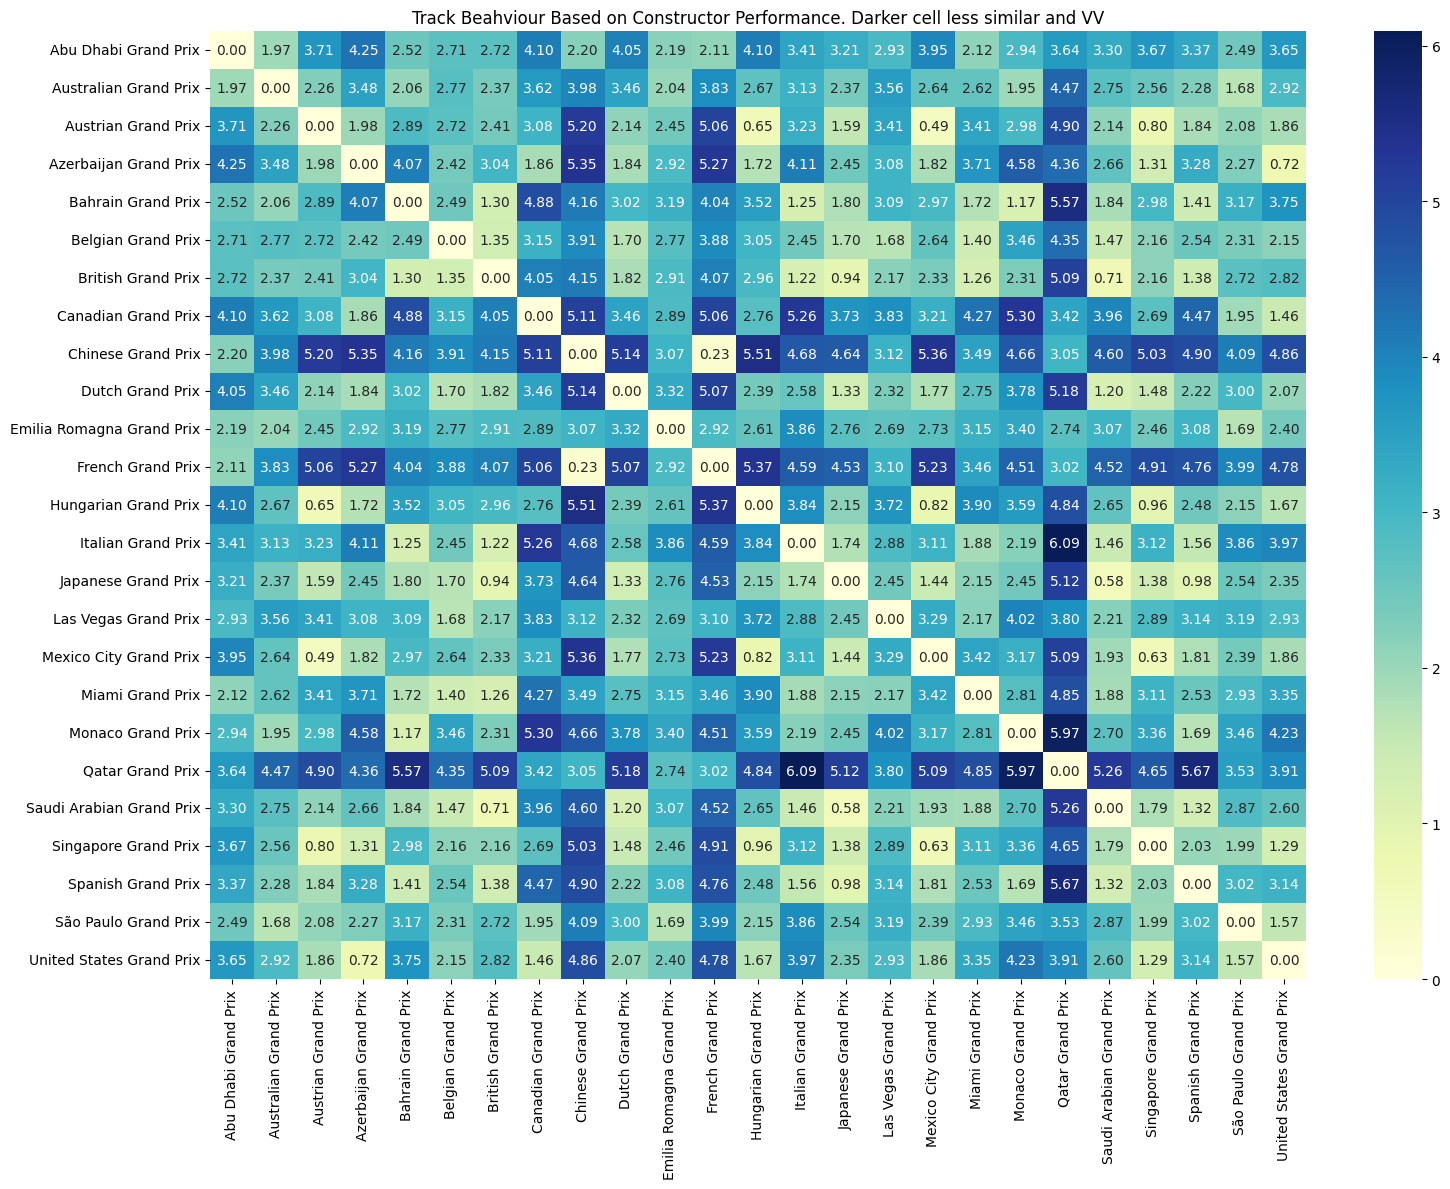

In [16]:
# Let's compute track-wise averages and check similarities using clustering or correlation

# First, create a pivot table: average stats per track
track_summary = constructor_summary_df.groupby("race_name").agg({
    "total_points": "mean",
    "avg_finish_position": "mean",
    "avg_grid_position": "mean",
    "grid_finish_delta": "mean",
    "dnf_count": "sum"
}).reset_index()

# Normalize values for similarity comparison
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

features = track_summary.drop(columns="race_name")
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Compute distance matrix
distance_matrix = squareform(pdist(scaled_features, metric='euclidean'))

# Plot heatmap of similarity (lower distance = more similar)
plt.figure(figsize=(16, 12))
sns.heatmap(distance_matrix, xticklabels=track_summary["race_name"],
            yticklabels=track_summary["race_name"], cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Track Beahviour Based on Constructor Performance. Darker cell less similar and VV")
plt.tight_layout()
plt.show()

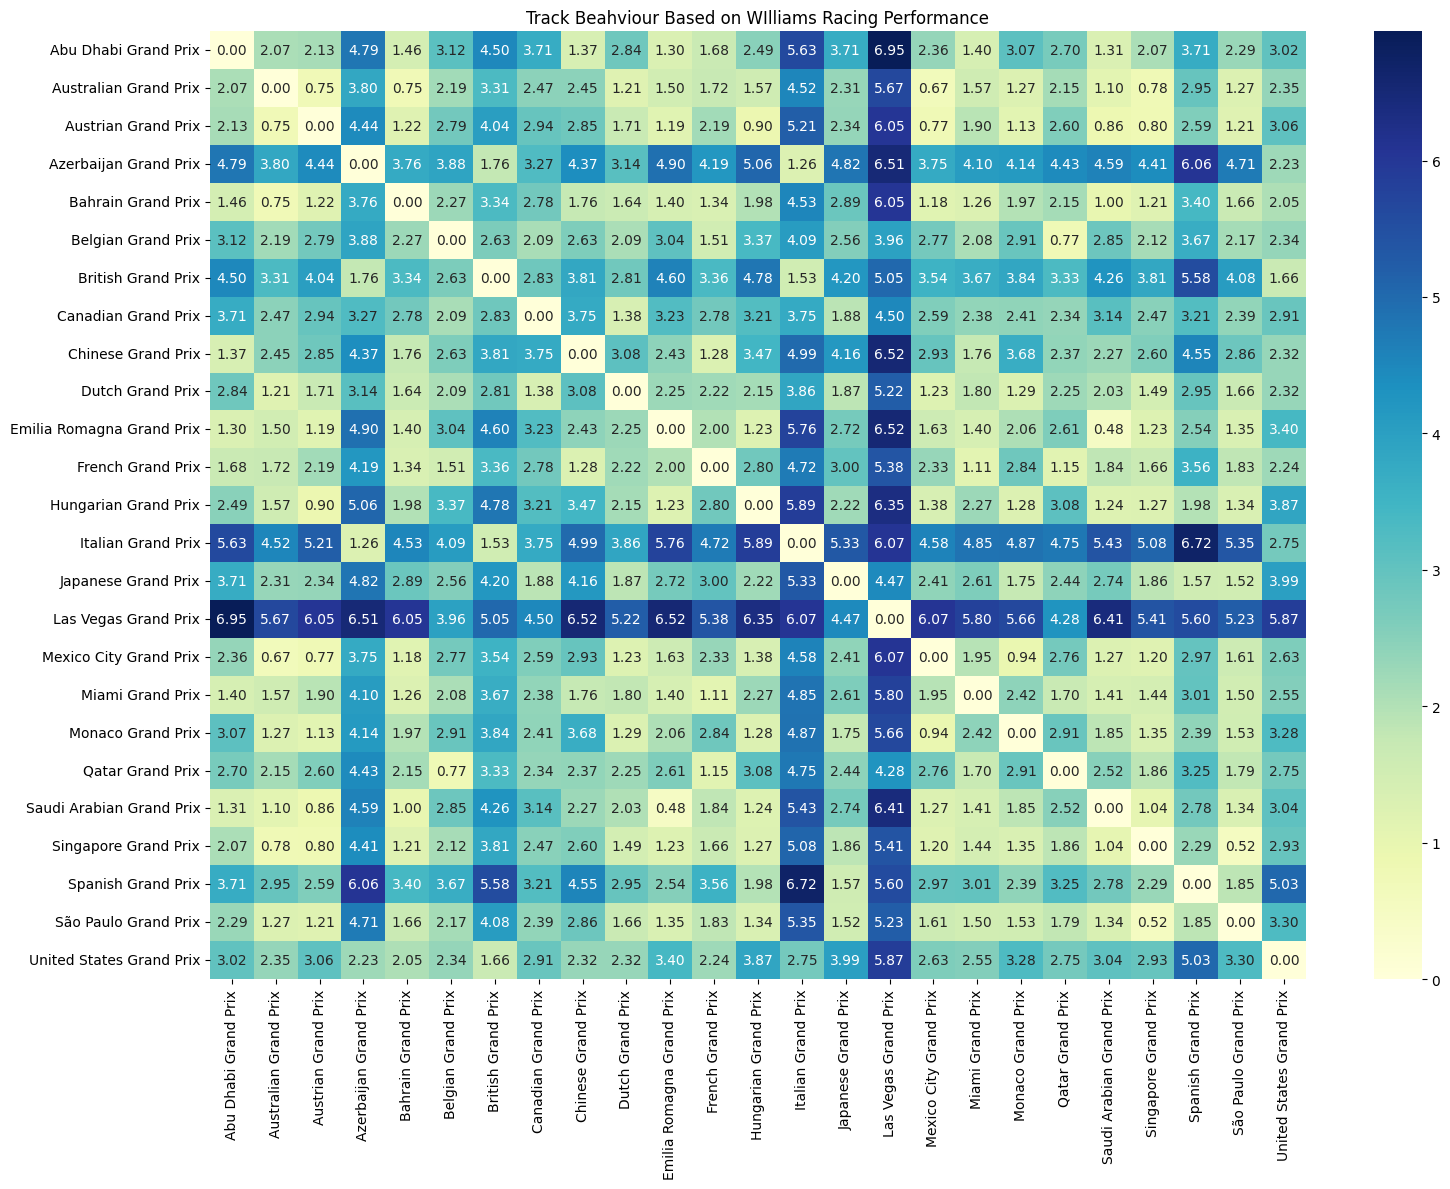

In [57]:
williams_df = constructor_summary_df[constructor_summary_df["constructor"].str.contains("williams", case=False)]

williams_track_summary = williams_df.groupby("race_name").agg({
    "total_points": "mean",
    "avg_finish_position": "mean",
    "avg_grid_position": "mean",
    "grid_finish_delta": "mean",
    "dnf_count": "sum"
}).reset_index()

features = williams_track_summary.drop(columns="race_name")
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Compute distance matrix
distance_matrix = squareform(pdist(scaled_features, metric='euclidean'))

# Plot heatmap of similarity (lower distance = more similar)
plt.figure(figsize=(16, 12))
sns.heatmap(distance_matrix, xticklabels=track_summary["race_name"],
            yticklabels=track_summary["race_name"], cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Track Beahviour Based on WIlliams Racing Performance")
plt.tight_layout()
plt.show()

In [18]:
## We use emilia like tracks based on the heatmap above using euclidean geometry to gauge similarities
emilia_like_tracks = ["Miami Grand Prix", "Mexico City Grand Prix", "Saudi Arabian Grand Prix",
    "Singapore Grand Prix", "São Paulo Grand Prix", "Emilia Romagna Grand Prix"]

In [19]:
# Filter constructor-level summary for Williams only on Emilia-like tracks
williams_cluster = constructor_summary_df[
    (constructor_summary_df["constructor"].str.contains("williams", case=False)) &
    (constructor_summary_df["race_name"].isin(emilia_like_tracks))
].copy()

williams_cluster["track_cluster"] = "Group_Emilia"

In [ ]:
###Here we are finding drivers specific to williams 
williams_drivers_df = full_results_df[
    (full_results_df["constructor"].str.contains("williams", case=False)) &
    (full_results_df["race_name"].isin(emilia_like_tracks))
].copy()

In [24]:
williams_team_summary = constructor_summary_df[
    constructor_summary_df["constructor"].str.contains("williams", case=False)
][["race_name", "total_points", "avg_finish_position", "avg_grid_position", "grid_finish_delta", "dnf_count"]]

In [25]:
# Ensure constructor column is string to avoid merge issues
constructor_summary_df["constructor"] = constructor_summary_df["constructor"].astype(str)

# Define track cluster
emilia_like_tracks = [
    "Miami Grand Prix", "Mexico City Grand Prix", "Saudi Arabian Grand Prix",
    "Singapore Grand Prix", "São Paulo Grand Prix", "Emilia Romagna Grand Prix"
]

# Filter team-level summary
williams_cluster = constructor_summary_df[
    (constructor_summary_df["constructor"].str.contains("williams", case=False)) &
    (constructor_summary_df["race_name"].isin(emilia_like_tracks))
].copy()
williams_cluster["track_cluster"] = "Group_Emilia"

# Prepare summary table (1 row per race for merge)
williams_team_summary = williams_cluster[[
    "race_name", "total_points", "avg_finish_position", "avg_grid_position",
    "grid_finish_delta", "dnf_count", "track_cluster"
]]

# Merge team features into driver-level data
enriched_df = pd.merge(
    williams_drivers_df,
    williams_team_summary,
    on="race_name",
    how="left",
    suffixes=("", "_team")
)

In [26]:
enriched_df = pd.merge(
    williams_drivers_df,
    williams_team_summary,
    on="race_name",
    how="left",
    suffixes=("", "_team")
)

In [27]:
# Ensure correct types
full_results_df["race_date"] = pd.to_datetime(full_results_df["race_date"])
full_results_df["constructor"] = full_results_df["constructor"].astype(str)

# Define emilia-like tracks
emilia_like_tracks = [
    "Miami Grand Prix", "Mexico City Grand Prix", "Saudi Arabian Grand Prix",
    "Singapore Grand Prix", "São Paulo Grand Prix", "Emilia Romagna Grand Prix"
]

In [28]:

# Step 1: Filter full driver data for emilia-like tracks
driver_df = full_results_df[
    full_results_df["race_name"].isin(emilia_like_tracks)
].copy()

# Step 2: Compute constructor-level team summary for each race
team_summary = driver_df.groupby(["race_name", "constructor"]).agg(
    avg_grid_position=("grid", "mean"),
    avg_finish_position=("position", "mean"),
    dnf_count=("status", lambda s: s.str.contains("DNF|Collision|Withdrew|Accident", case=False).sum()),
    total_points=("points", "sum")
).reset_index()

team_summary["grid_finish_delta"] = (
    team_summary["avg_finish_position"] - team_summary["avg_grid_position"]
)

# Step 3: Merge team summary into driver data
enriched_driver_df = pd.merge(
    driver_df,
    team_summary,
    on=["race_name", "constructor"],
    how="left"
)

# Step 4: Sort for rolling features
enriched_driver_df = enriched_driver_df.sort_values(by=["driver_id", "race_date"])

# Step 5: Rolling form features (last 3 races)
enriched_driver_df["driver_form_last_3"] = enriched_driver_df.groupby("driver_id")["position"]\
    .transform(lambda x: x.shift().rolling(3, min_periods=1).mean())

enriched_driver_df["grid_form_last_3"] = enriched_driver_df.groupby("driver_id")["grid"]\
    .transform(lambda x: x.shift().rolling(3, min_periods=1).mean())

enriched_driver_df["team_points_last_3"] = enriched_driver_df.groupby("constructor")["total_points"]\
    .transform(lambda x: x.shift().rolling(3, min_periods=1).mean())

# Step 6: DNF flag
enriched_driver_df["dnf_flag"] = enriched_driver_df["status"].apply(
    lambda x: 1 if "DNF" in str(x) or "Collision" in str(x) or "Withdrew" in str(x) or "Accident" in str(x) else 0
)


In [159]:
# Step 1: Use all race data
driver_df = full_results_df.copy()
driver_df["race_date"] = pd.to_datetime(driver_df["race_date"])
driver_df["constructor"] = driver_df["constructor"].str.lower().str.strip()
driver_df["driver_id"] = driver_df["driver_id"].str.lower().str.strip()

# Step 2: Compute constructor-level team summary
team_summary = driver_df.groupby(["race_name", "constructor"]).agg(
    avg_grid_position=("grid", "mean"),
    avg_finish_position=("position", "mean"),
    dnf_count=("status", lambda s: s.str.contains("DNF|Collision|Withdrew|Accident", case=False).sum()),
    total_points=("points", "sum")
).reset_index()

# Grid-finish delta
team_summary["grid_finish_delta"] = (
    team_summary["avg_finish_position"] - team_summary["avg_grid_position"]
)

# Step 3: Merge team summary into driver-level data
enriched_driver_df = pd.merge(
    driver_df,
    team_summary,
    on=["race_name", "constructor"],
    how="left"
)

# Step 4: Sort chronologically per driver
enriched_driver_df = enriched_driver_df.sort_values(by=["driver_id", "race_date"])

# Step 5: Add rolling features (3-race form)
enriched_driver_df["driver_form_last_3"] = enriched_driver_df.groupby("driver_id")["position"]\
    .transform(lambda x: x.shift().rolling(3, min_periods=1).mean())
enriched_driver_df["grid_form_last_3"] = enriched_driver_df.groupby("driver_id")["grid"]\
    .transform(lambda x: x.shift().rolling(3, min_periods=1).mean())
enriched_driver_df["team_points_last_3"] = enriched_driver_df.groupby("constructor")["total_points"]\
    .transform(lambda x: x.shift().rolling(3, min_periods=1).mean())

# Step 6: DNF flag
enriched_driver_df["dnf_flag"] = enriched_driver_df["status"].apply(
    lambda x: 1 if "DNF" in str(x) or "Collision" in str(x) or "Withdrew" in str(x) or "Accident" in str(x) else 0
)

# Step 7: Albon tag for prediction targeting
enriched_driver_df["is_albon"] = enriched_driver_df["driver_id"] == "albon"


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Function to prepare, train, and predict driver position
def train_and_predict_driver(enriched_df, driver_id, target_race="Emilia Romagna Grand Prix"):
    # Filter for the driver
    df = enriched_df[enriched_df["driver_id"].str.lower() == driver_id.lower()].copy()

    # Drop irrelevant or identifier columns
    drop_cols = [
        "season", "round", "race_date", "driver_name", "constructor",
        "status", "points", "driver_id", "race_name", "is_albon"
    ]
    df_clean = df.drop(columns=drop_cols, errors="ignore")
    
    # Drop rows missing essential features
    essential_cols = ["position", "grid", "driver_form_last_3", "grid_form_last_3", "team_points_last_3"]
    df_clean = df_clean.dropna(subset=essential_cols)

    # Split features and target
    X = df_clean.drop(columns="position")
    y = df_clean["position"]

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5  # manually take the square root

    r2 = r2_score(y_test, y_pred)

    # Predict for latest Emilia GP
    test_row = df[df["race_name"] == target_race].sort_values("race_date").tail(1).copy()
    test_input = test_row.drop(columns=drop_cols + ["position"], errors="ignore").dropna()
    if test_input.empty:
        predicted_position = None
    else:
        test_scaled = scaler.transform(test_input)
        predicted_position = model.predict(test_scaled)[0]

    return predicted_position, rmse, r2

# Map position to FIA points
def position_to_points(pos):
    points_map = {1:25, 2:18, 3:15, 4:12, 5:10, 6:8, 7:6, 8:4, 9:2, 10:1}
    if pos is None:
        return 0
    return points_map.get(int(round(pos)), 0)

# Run prediction for Albon and Sainz
albon_pos, albon_rmse, albon_r2 = train_and_predict_driver(enriched_driver_df, "albon")
sainz_pos, sainz_rmse, sainz_r2 = train_and_predict_driver(enriched_driver_df, "sainz")

# Convert predicted positions to points
albon_points = position_to_points(albon_pos)
sainz_points = position_to_points(sainz_pos)

# Total constructor points
williams_total_points = albon_points + sainz_points

print(f"🔵 Albon predicted position: {albon_pos:.2f} → {albon_points} points")
print(f"🔴 Sainz predicted position: {sainz_pos:.2f} → {sainz_points} points")
print(f"🏁 Total predicted constructor points for Williams Racing: {williams_total_points} points")


🔵 Albon predicted position: 18.20 → 0 points
🔴 Sainz predicted position: 5.35 → 10 points
🏁 Total predicted constructor points for Williams Racing: 10 points


In [ ]:
# ### 🧠 **F1 Prediction Pipeline Mind Map**

# #### 🟢 1. **Raw Data Ingestion**

# * Source: Ergast API / existing dataset (`full_results_df`)
# * Data includes: `driver_id`, `constructor`, `position`, `grid`, `race_name`, `points`, `status`, `race_date`

# ---

# #### 🔵 2. **Data Enrichment → `enriched_driver_df`**

# Adds extra context to each driver’s row:

# | Enrichment            | Purpose                       |
# | --------------------- | ----------------------------- |
# | `avg_grid_position`   | Team’s qualifying performance |
# | `avg_finish_position` | Team’s race-day performance   |
# | `grid_finish_delta`   | Strategy effectiveness        |
# | `team_points_last_3`  | Rolling team momentum         |
# | `driver_form_last_3`  | Driver’s recent finish trend  |
# | `grid_form_last_3`    | Driver’s recent grid trend    |
# | `dnf_flag`            | Reliability metric            |
# | `is_albon` (optional) | For special targeting         |

# ---

# #### 🔶 3. **Per-Driver Modeling**

# Function: `train_and_predict_driver(enriched_driver_df, driver_id, target_race)`

# | Step                    | What it does                                 |
# | ----------------------- | -------------------------------------------- |
# | Subset data for driver  | Train on only that driver’s historical races |
# | Clean missing data      | Focus on essential predictive features       |
# | Train model             | `RandomForestRegressor()` per driver         |
# | Evaluate                | RMSE + R² metrics on hold-out data           |
# | Predict future position | e.g., at Emilia Romagna GP                   |

# ---

# #### 🔴 4. **Position → Points Mapping**

# Function: `position_to_points(pos)`


# ---

# #### 🟣 5. **Constructor Points Estimation**

# * Run `train_and_predict_driver()` for **Albon** and **Sainz**
# * Convert their predicted positions to points
# * Sum both for:

#   ```python
#   williams_total_points = albon_points + sainz_points
#   ```

# ---

# #### 🟠 6. **Final Output**

# ```plaintext
# 🔵 Albon predicted position: 18 → 0 points
# 🔴 Sainz predicted position: 5 → 10 points
# 🏁 Total predicted constructor points for Williams: 10 points
# ```